En este notebook efectuaremos el análisis de sentimientos de las reviews de los usuario de alojamientos y sitios de comida. 
Utilizaremos Wordcloud para generar nubes de palabras y extraer conclusiones

In [2]:
# Importamos la libreria Pandas para el manejo de dataframes
import pandas as pd

In [3]:
# Importamos el dataset conteniendo los datos del os comercios
metadata = pd.read_csv(r"metadata_powerbi.csv")

In [4]:
# Visualizamos el dataframe generado
metadata

,Unnamed: 0,name,address,gmap_id,description,latitude,longitude,category,avg_rating,num_of_reviews,...,misc,relative_results,url,city,cp,state,Cat_Id,Description,Group_Id,Group
0,0,San Soo Dang,"San Soo Dang, 761 S Vermont Ave, Los Angeles, ...",0x80c2c778e3b73d33:0xbdc58662a4a97d49,NaN,34.058092,-118.292130,Korean restaurant,4.4,18,...,"{'Service options': ['Takeout', 'Dine-in', 'De...","['0x80c2c78249aba68f:0x35bf16ce61be751d', '0x8...",https://www.google.com/maps/place//data=!4m2!3...,Los Angeles,90005,CA,5,Korean restaurant,1,Comida
1,1,Ahi - R&D House,"Ahi - R&D House, 940 S Gilbert Rd #2, Gilbert,...",0x872ba9240f2eabb7:0x6539ede3ea401a19,NaN,33.332435,-111.791137,Korean restaurant,5.0,2,...,"{'Service options': ['Delivery', 'Takeout'], '...","['0x872baefd83cde281:0xcea7c0735ed506ae', '0x8...",https://www.google.com/maps/place//data=!4m2!3...,Gilbert,85296,AZ,5,Korean restaurant,1,Comida
2,2,Kim's Kitchen,"Kim's Kitchen, Above Palace Spa, 1727 S 316th ...",0x549057a7db40d70d:0xe085b6f6463ca410,NaN,47.318445,-122.311246,Korean restaurant,4.7,13,...,"{'Service options': ['Delivery', 'Takeout'], '...",NaN,https://www.google.com/maps/place//data=!4m2!3...,Federal Way,98003,WA,5,Korean restaurant,1,Comida
3,3,Kook Bin,"Kook Bin, 13069 Wisteria Dr, Germantown, MD 20874",0x89b62c3d880935df:0xfcc6c5f9e7e0a627,NaN,39.178581,-77.271384,Korean restaurant,4.2,27,...,"{'Service options': ['Takeout', 'Dine-in', 'De...","['0x89b62c3d880935df:0x79a91fe5b0017294', '0x8...",https://www.google.com/maps/place//data=!4m2!3...,Germantown,20874,MD,5,Korean restaurant,1,Comida
4,4,Toyose,"Toyose, 3814 Noriega St, San Francisco, CA 94122",0x8085878a8085d297:0xadf6a9f9923446f2,NaN,37.753200,-122.504702,Korean restaurant,4.5,14,...,"{'Service options': ['Delivery', 'Takeout', 'D...",NaN,https://www.google.com/maps/place//data=!4m2!3...,San Francisco,94122,CA,5,Korean restaurant,1,Comida
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
329532,329532,Eatfit Food Truck,"Eatfit Food Truck, 7777 N Heartland Dr, Coeur ...",0x5361c123a062e72b:0xe9238e78df994bf0,NaN,47.743831,-116.799903,Macrobiotic restaurant,4.5,2,...,"{'Service options': ['Delivery', 'Takeout'], '...",NaN,https://www.google.com/maps/place//data=!4m2!3...,Coeur d'Alene,83815,ID,419,Macrobiotic restaurant,1,Comida
329533,329533,Moobongri,"Moobongri, 1300 San Pedro St, Los Angeles, CA ...",0x80c2c7d2e76ad7d9:0xd40ca6f74f9c441a,NaN,34.032258,-118.254136,Soondae restaurant,4.1,8,...,{'Service options': ['Delivery']},"['0x80c2c78073cc019d:0x678e86acdfe52fa', '0x80...",https://www.google.com/maps/place//data=!4m2!3...,Los Angeles,90015,CA,424,Soondae restaurant,1,Comida
329534,329534,Cháo Đêm,"Cháo Đêm, 9754 Garden Grove Blvd, Garden Grove...",0x80dd28798611e063:0xc6f65143e5c71e18,NaN,33.772999,-117.962427,Porridge restaurant,3.8,236,...,"{'Service options': ['Takeout', 'Dine-in', 'De...","['0x80dd270cbc6fdd05:0x49edfc8bc513a022', '0x8...",https://www.google.com/maps/place//data=!4m2!3...,Garden Grove,92844,CA,360,Porridge restaurant,1,Comida
329535,329535,High Country Smokehouse,"High Country Smokehouse, 702 W Trimble Ave, Be...",0x87cec5581b8eb5e7:0x35cbfdf4a48a817f,NaN,36.371808,-93.580830,Offal barbecue restaurant,4.8,85,...,"{'Service options': ['Takeout', 'Delivery'], '...","['0x87cec5423182a445:0x9111f1233888eef5', '0x8...",https://www.google.com/maps/place//data=!4m2!3...,Berryville,72616,AR,433,Offal barbecue restaurant,1,Comida


In [ ]:
# Importamos el dataset con las reseñas de los usuarios
reviews = pd.read_csv(r"datasets_limpios\full_reviews.csv")

In [6]:
# Eliminamos columnas que no usaremos en esta parte del análisis
# Para las nubes de palabras no necesitamos identificar a los usuarios
# ni datos relativos a la respuesta del comercio, los tiempos o las fotos
reviews = reviews.drop(["user_id","name","time","resp", "resp.time", "resp.text", "pics"], axis=1)

In [7]:
# Por otro lado, al enfocarnos en analizar el texto de la reseña, eliminamos
# aquellas reviews que solo contienen un puntaje pero un texto que lo justifique
reviews.dropna(inplace=True, subset="text")

In [8]:
# Para poder realizar análisis individuales por tipo de comercio, incorporamos
# mediante un join ese dato al dataframe (Alojamiento, Comida u Ocio)
reviews_group = pd.merge (reviews, metadata, left_on= "gmap_id", right_on= "gmap_id")

A continuación, preparamos un dataframe para cada tipo de comercio, separando las reviews positivas de las negativas

In [9]:
# Generamos el dataframe de Alojamientos
reviews_alojamiento = reviews_group[reviews_group["Group"] == "Alojamiento"]

In [10]:
# Generamos el dataframe de alojamientos con reviews positivas. Al contar con menos
# reseñas  que cuando se trata de comercios de comida, tomamos puntajes 4 y 5 como 
# reseñas positivas y 1 y 2 como negativas
reviews_alojamiento_buenas = reviews_alojamiento[reviews_alojamiento["rating"] >3]

In [11]:
# Generamos el dataframe con reviews negativas de alojamientos
reviews_alojamiento_malas = reviews_alojamiento[reviews_alojamiento["rating"] <3]

Generamos ahora las nubes de palabras de los Alojamientos

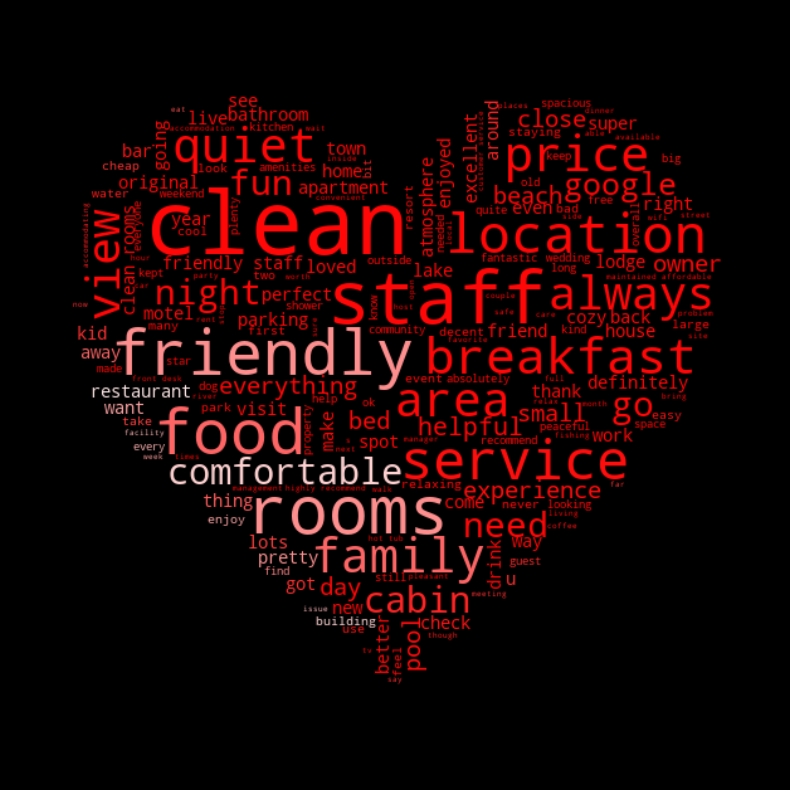

In [12]:
# Importamos las librerias necesarias para medir la frecuencia de cada palabra,
# eliminando artículos y similares, generar las nubes de palabras y graficarlas.
from wordcloud import WordCloud, ImageColorGenerator, STOPWORDS
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

# Tomamos la imagen de un corazón para el primer Wordcloud.
# Aclaramos que luego de generar el primer Wordcloud, y verificar que las palabras
# mas comunes eran adjetivos o palabras con connotacion positiva (lo que nos
# permitió corroborar que no era necesario realizar procesamiento del lenguaje
# natural y podíamos dar por válido el rating como indicador del sentimiento
# de cada review, las eliminamos de modo que se visualizaran mejor las palabras
# de interés para arribar a nuestras conclusiones.
# Este ciclo se reiteró para cada Wordcloud, por lo que las stopwords que se
# detallan debajo son las que se fueron incorporando a la lista en cada iteración
comment_words = ''
stopwords = ["room", "good", "amazing", "stayed", "time", "will", "lot", "awesome", "stay", "great", "alway", "well", "one", "love", "best", "went", "place", "wonderful", "translated", "nice", "hotel", "little", "really", "much", "lovely", "beautiful", "people", ""] + list(STOPWORDS)
maska = np.array(Image.open("datasets_limpios/heart.jpg"))

# Iteramos a través de las filas
for val in reviews_alojamiento_buenas.text:
     
    # Pasamos cada valor a string
    val = str(val)
 
    # Separamos cada palabra
    tokens = val.split()
     
    # Las convertimos en minúsculas
    for i in range(len(tokens)):
        tokens[i] = tokens[i].lower()
    
    # Las incorporamos a una lista
    comment_words += " ".join(tokens)+" "

# Generamos la nube de palabra y la graficamos 
wc = WordCloud(background_color="black", max_words=300, mask=maska,
               max_font_size=70, min_font_size= 5, random_state=42, stopwords= stopwords)
wc.generate(comment_words)

image_colors = ImageColorGenerator(maska)
plt.figure(figsize=[10,10], facecolor='k')
plt.imshow(wc.recolor(color_func=image_colors), interpolation="bilinear")
plt.axis("off")
plt.show()

Repetimos todo el procedimiento pero en esta caso para las malas reseñas, las que graficamos con un corazón roto

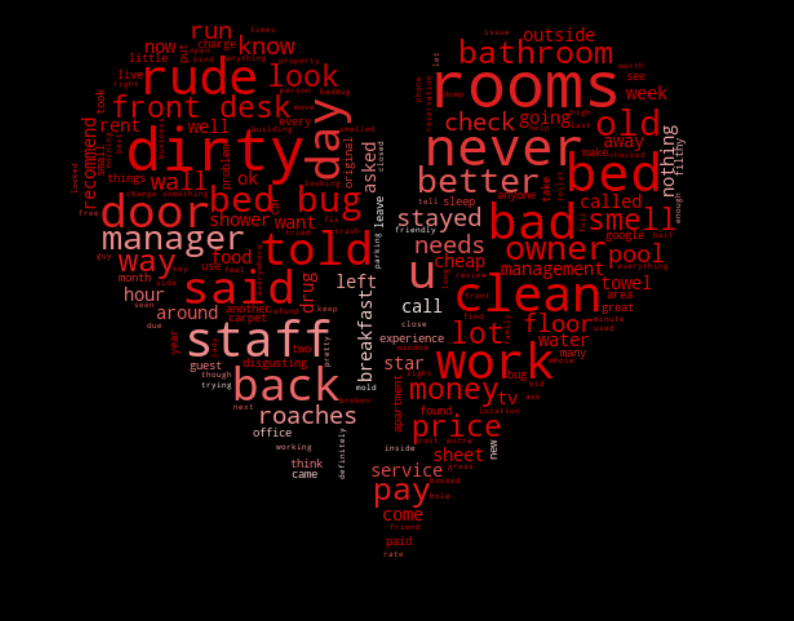

In [151]:
comment_words = ''
stopwords = ["room", "still", "say", "much", "good", "really", "people", "really", "went", "give", "made", "terrible", "someone", "worst", "thing", "place", "hotel", "stay", "one", "time", "got", "first", "motel", "even", "horrible", "translated", "staying", "will", "night", "nasty", "nice", "need", "go"] + list(STOPWORDS)
maska = np.array(Image.open("datasets_limpios/roto.jpg"))
 

for val in reviews_alojamiento_malas.text:
     
    val = str(val)

    tokens = val.split()
     
    for i in range(len(tokens)):
        tokens[i] = tokens[i].lower()
     
    comment_words += " ".join(tokens)+" "
 
wc = WordCloud(background_color="black", max_words=300, mask=maska,
               max_font_size=50, min_font_size= 5, random_state=42, stopwords= stopwords)
wc.generate(comment_words)

image_colors = ImageColorGenerator(maska)
plt.figure(figsize=[10,10], facecolor='k')
plt.imshow(wc.recolor(color_func=image_colors), interpolation="bilinear")
plt.axis("off")
plt.show()

Generamos ahora los dataframes de sitios de comida, dividios en reseñas malas y 
buenas, y como indicamos mas arriba, al contar con una mayor cantidad, tomamos 
solo el valor 5 como positivas y el 1 como negativas

In [11]:
reviews_comida = reviews_group[reviews_group["Group"] == "Comida"]
reviews_comida = reviews_comida.drop(["gmap_id","name","address","description","latitude","longitude","misc","relative_results","url","city","cp","state","Cat_Id","Description","Group_Id","Group"],axis=1)
reviews_comida = reviews_comida.drop(["Unnamed: 0","avg_rating","num_of_reviews","price","hours"],axis=1)
reviews_comida_buenas = reviews_comida[reviews_comida["rating"] >4]
reviews_comida_malas = reviews_comida[reviews_comida["rating"] <2]

In [12]:
# Al no contar con poder de procesamiento suficiente para considerar todos los 
# datos, seleccionamos 200.000 reseñas al azar para el caso de las positivas
reviews_comida_buenas = reviews_comida_buenas.sample(n=200000, random_state=42)

In [13]:
# Visualizamos el Dataframe
reviews_comida_buenas

,rating,text,category
2970608,5,Family friendly and great home cooked meals,American restaurant
114589,5,"Great value, super service.",American restaurant
1061244,5,(Translated by Google) Very good place to eat\...,Mexican restaurant
2031908,5,"Good food, decent prices, friendly service.",Mexican restaurant
120646,5,Beautiful elegant dining.,Restaurant
...,...,...,...
1224924,5,It is really good,Restaurant
3112391,5,"Awesome food, clean, great service.",Thai restaurant
2700632,5,I've been past this place a million times & th...,Italian restaurant
3618769,5,Stopped on a beautiful September afternoon whe...,American restaurant


Repetimos los pasos anteriores, graficando con una flecha verde las reseñas
positivas y con una flecha roja las negativas

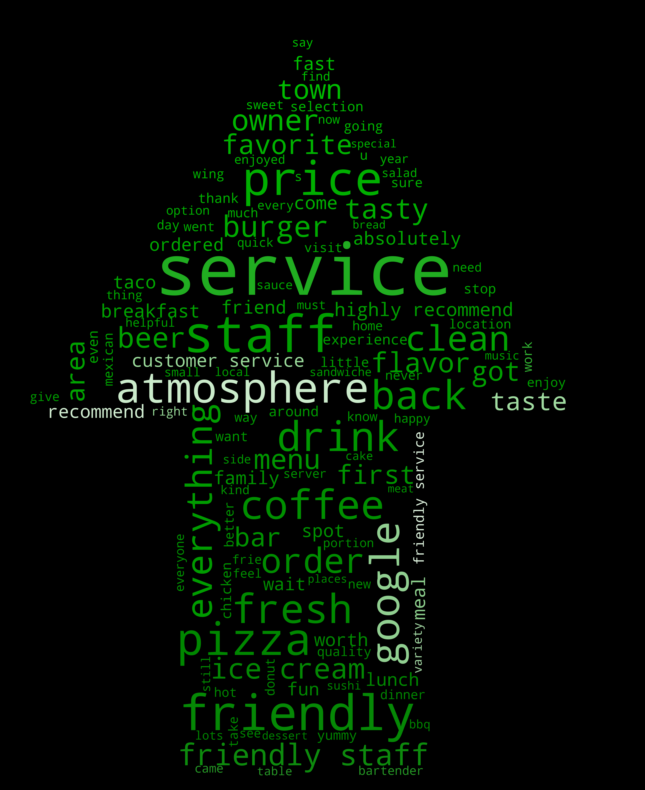

In [14]:
from wordcloud import WordCloud, ImageColorGenerator, STOPWORDS
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image


maska = np.array(Image.open("datasets_limpios/verde.png"))
comment_words = ''
stopwords = ["go", "amazing", "excellent", "alway", "loved", "will", "tried", "restaurant", "nice", "one", "place", "great", "really", "food", "good", "delicious", "love", "awesome", "best", "translated", "eat", "people", "try", "always", "time", "well", "lot", "perfect", "fantastic", "make", "made", "super", "wonderful", "definitely"] + list(STOPWORDS)
 
for val in reviews_comida_buenas.text:

    val = str(val)
 
    tokens = val.split()
     
    for i in range(len(tokens)):
        tokens[i] = tokens[i].lower()
     
    comment_words += " ".join(tokens)+" "
 
wc = WordCloud(background_color="black", max_words=300, mask=maska,
               max_font_size=400, min_font_size= 60, random_state=42, stopwords= stopwords)
wc.generate(comment_words)

image_colors = ImageColorGenerator(maska)
plt.figure(figsize=[10,10], facecolor='k')
plt.imshow(wc.recolor(color_func=image_colors), interpolation="bilinear")
plt.axis("off")
plt.show()

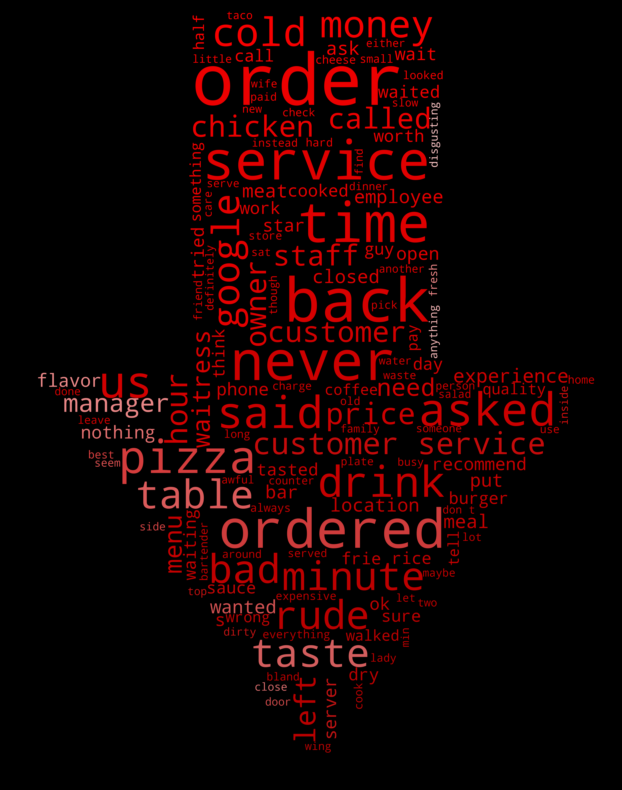

In [18]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt

maska = np.array(Image.open("datasets_limpios/roja.png"))
comment_words = ''
stopwords = ["even", "u", "come", "thing", "review", "first", "eating", "took", "gave", "look", "right", "food", "much", "going", "today", "worst", "horrible", "made", "now", "alway", "used", "decided", "translated", "good", "told", "went", "came", "will", "one", "got", "know", "eat", "restaurant", "better", "go", "place", "want", "still", "give", "people", "try", "take", "see", "nasty", "business", "disappointed", "make", "well", "really", "great", "terrible", "say", "way", "nice"] + list(STOPWORDS)
 
for val in reviews_comida_malas.text:
     
    val = str(val)
 
    tokens = val.split()
     
    for i in range(len(tokens)):
        tokens[i] = tokens[i].lower()
     
    comment_words += " ".join(tokens)+" "
 
wc = WordCloud(background_color="black", max_words=300, mask=maska,
               max_font_size=400, min_font_size= 60, random_state=42, stopwords= stopwords)
wc.generate(comment_words)

image_colors = ImageColorGenerator(maska)
plt.figure(figsize=[10,10], facecolor='k')
plt.imshow(wc.recolor(color_func=image_colors), interpolation="bilinear")
plt.axis("off")
plt.show()